In [1]:
import pandas as pd
from pymongo import MongoClient

connection = MongoClient(
    host="research.cassee.dev",
    username="read-shark",
    password="msr2021shark")

db = connection.smartshark_2_1

In [2]:
#print(len(list(db.issue.find())), "total issues")  # --> 163057 db.issue.count() or db.issue.find().count() does not seem to work
#print(len(list(db.issue.find({'issue_type' : {'$exists': True}}))), "issues containing an issue_type field")  # --> 158222
#print(len(list(db.issue.find({'issue_type_verified': {'$exists': True }}, {'issue_type': 1, 'issue_type_verified' : 1}))), # --> 15517
#      "issues containing both issue_type and issue_type_verified")  # note, every issue with issue_type_verified also has an issue_type
print(len(list(db.issue.find({'issue_type' : {'$exists': True}, 'desc':{'$exists': True}}))), "issues containing an issue_type and description field")  # --> 146662


146662 issues containing an issue_type and description field


In [3]:
# Query all issues which have an issue type (158222 out of 163057 total issues)
issues = list(db.issue.find({'issue_type': {'$exists': True }, 'desc':{'$exists': True}}, {'_id': 1, 'external_id': 1, 'creator_id':1, 'title': 1, 'issue_type': 1, 'issue_type_verified': 1, 'priority': 1, 'status': 1, 'resolution': 1, 'desc': 1}))

# Convert to dataframe
df = pd.DataFrame(issues)
df.head()

,_id,external_id,title,desc,creator_id,issue_type,priority,status,resolution,issue_type_verified
0,58bfca910ccb2667fe269dd1,ZOOKEEPER-24,Do Application based outstanding request throt...,Moved from SourceForge to Apache.\nhttp://sour...,58b938adf04620b395fccf94,New Feature,Major,Open,NaN,NaN
1,58bfca920ccb2667fe269dd2,ZOOKEEPER-35,Replay logs,Moved from SourceForge to Apache.\nhttp://sour...,58b938adf04620b395fccf94,New Feature,Major,Open,NaN,NaN
2,58bfca930ccb2667fe269dd3,ZOOKEEPER-37,WebDAV access to ZooKeeper,Moved from SourceForge to Apache.\nhttp://sour...,58b938adf04620b395fccf94,New Feature,Major,Open,NaN,NaN
3,58bfca930ccb2667fe269dd4,ZOOKEEPER-46,Clients should check the latencies to the vari...,When ZooKeeper clients and servers are on the ...,58b938adf04620b39bfccf95,Improvement,Major,Open,NaN,NaN
4,58bfca940ccb2667fe269dd7,ZOOKEEPER-52,Session ids on the stat cmd information,Currently there is not a way to correlate sess...,58b938adf04620b39bfccf95,Improvement,Minor,Open,NaN,NaN


## Issue Types (Verified)

In [4]:
# Combine issue type and issue type verified, such that if there is a verified type we pick that, otherwise keep the original issue type
df['new_issue_type'] = df['issue_type_verified'].combine_first(df['issue_type'])

# drop the old issue types and rename new_issue_type to issue_type
df = df.drop(columns = ['issue_type', 'issue_type_verified'])
df = df.rename(columns={'new_issue_type': 'issue_type'})

In [5]:
# put all issue types in lowercase
df['issue_type'] = df['issue_type'].apply(lambda x: x.lower())
print("All issue type currently present:\n", df['issue_type'].value_counts())

# grouping of values which mean the same but have different labels
feature_equivs = ['improvement', 'new feature', 'wish', 'feature_request', 'brainstorming', 'request', 'proposal']
feature_val = 'feature'
task_equivs = ['sub-task', 'task', 'technical task']
task_val = 'task'
dependency_equivs = ['dependency upgrade', 'dependency']
dep_val = 'dependency'
other_equivs = ['other', 'epic', 'refactoring', 'temp', 'umbrella', 'story', 'blog - new blog request', 'tck challenge', 'it help', 'new jira project', 'access', 'blogs - new blog user account request', 'project', 'outage', 'new tlp ', 'new git repo', 'planned work']
other_val = 'other'

# mainly not sure what to do with: test, documentation, question, epic, refactoring, temp and umbrella

df['issue_type'] = df['issue_type'].apply(lambda val: feature_val if val in feature_equivs else val) 
df['issue_type'] = df['issue_type'].apply(lambda val: task_val if val in task_equivs else val) 
df['issue_type'] = df['issue_type'].apply(lambda val: dep_val if val in dependency_equivs else val) 
df['issue_type'] = df['issue_type'].apply(lambda val: other_val if val in other_equivs else val) 

print("\nCombined issue types:\n", df['issue_type'].value_counts())

All issue type currently present:
 bug                        78027
improvement                39626
new feature                 9036
sub-task                    6929
task                        6730
test                        1538
wish                        1351
other                       1181
documentation                999
feature_request              521
question                     303
dependency upgrade           113
refactoring                   90
epic                          76
story                         41
temp                          30
brainstorming                 20
umbrella                      19
blog - new blog request        6
dependency                     6
request                        4
it help                        3
new jira project               3
tck challenge                  3
technical task                 2
project                        1
outage                         1
new git repo                   1
planned work                   1
proposal

### Status

In [6]:
print("Initial unique status values\n", df['status'].value_counts(dropna=False))

# All issues have a statement (i.e. no nan values), interestingly blocked only occurs twice
# We'll only look at closed and resolved issues
df = df[(df['status'] == 'Closed') | (df['status'] == 'Resolved')]

print("\nFiltered status\n", df['status'].value_counts(dropna=False))

Initial unique status values
 Closed             75246
Resolved           43895
Open               25229
Patch Available     1049
Reopened             672
In Progress          569
Blocked                2
Name: status, dtype: int64

Filtered status
 Closed      75246
Resolved    43895
Name: status, dtype: int64


### Resolution

In [7]:
print("Initial unique resolution values:\n", df['resolution'].value_counts(dropna=False))

# grouping of values which mean the same but have different labels
resolved_equivs = ['Fixed', 'Done', 'Not A Bug', 'Resolved', 'Workaround', 'Works for Me', 'Delivered', 'Implemented', 'Staged']
resolved_val = 'Resolved'
unresolved_equivs = ["Won't Fix", 'Auto Closed', "Won't Do", "Abandoned", 'Unresolved', 'Pending Closed', 'REMIND']
unresolved_val = 'Unresolved'
invalid_equivs = ['Duplicate', 'Not A Problem', 'Invalid', 'Cannot Reproduce', 'Incomplete']
invalid_val = 'Invalid'

# Not a problem, not a bug -> invalid or resolved?
# information provided?   About half resolved, half closed
# Feedback Received?  About half resolved, half closed
# Later ?  Again about half resolved, half closed

df['resolution'] = df['resolution'].apply(lambda val: resolved_val if val in resolved_equivs else val) 
df['resolution'] = df['resolution'].apply(lambda val: unresolved_val if val in unresolved_equivs else val) 
df['resolution'] = df['resolution'].apply(lambda val: invalid_val if val in invalid_equivs else val) 
df['resolution'] = df['resolution'].apply(lambda val: invalid_val if str(val) == 'nan' else val)  # drop nans as .dropna() doesn't seem to work
df['resolution'] = df['resolution'].dropna()
print("\nCombined unique resolution values:\n", df['resolution'].value_counts(dropna=False))

Initial unique resolution values:
 Fixed                   91096
Won't Fix                6757
Duplicate                6542
Not A Problem            4215
Invalid                  2920
Cannot Reproduce         2565
Incomplete               2417
Done                      796
Implemented               323
Not A Bug                 319
Resolved                  269
Later                     246
Auto Closed               177
Won't Do                  119
Abandoned                 103
Information Provided       84
Workaround                 73
Unresolved                 47
Pending Closed             35
Works for Me               17
Feedback Received           9
Delivered                   5
NaN                         4
REMIND                      2
Staged                      1
Name: resolution, dtype: int64

Combined unique resolution values:
 Resolved                92899
Invalid                 18663
Unresolved               7240
Later                     246
Information Provided       

## Descriptions

In [10]:
#df = df[df['desc'].str.len() > 10]
df_plot = df
df_plot['desc_length'] = df_plot['desc'].str.len().astype(int)
df_plot['desc_length'].describe()

count    1.191410e+05
mean     1.089717e+03
std      1.139670e+04
min      0.000000e+00
25%      1.890000e+02
50%      3.930000e+02
75%      8.850000e+02
max      3.051514e+06
Name: desc_length, dtype: float64

array([[<AxesSubplot:title={'center':'desc_length'}>]], dtype=object)

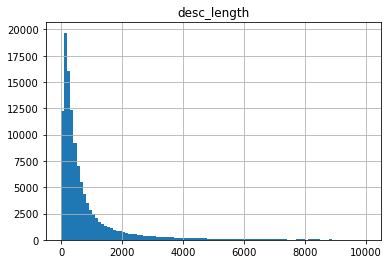

In [14]:
df_plot[(df_plot['desc_length'] > 0) & (df_plot['desc_length'] < 10000)].hist(column='desc_length', bins=100)